In [182]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

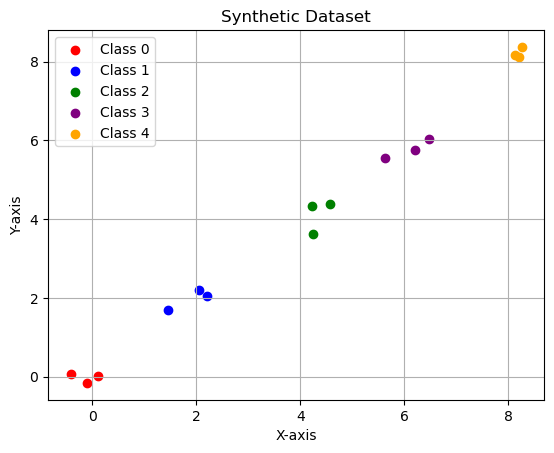

In [183]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_classes, n_points, base_covariance, shift):
    """
    Generate synthetic data.
    
    Parameters:
        n_classes (int): The number of classes.
        n_points (int): The number of points per class.
        base_covariance (list of list of float): The base covariance matrix for generating points.
        shift (float): The shift in the mean for each subsequent class.
        
    Returns:
        X (np.ndarray): The feature array.
        y (np.ndarray): The label array.
    """
    
    X_list = []
    y_list = []
    
    for i in range(n_classes):
        # Mean for class i (shifted along the line y=x)
        mean = [i * shift, i * shift]
        
        # Generate points for class i
        x, y = np.random.multivariate_normal(mean, base_covariance, n_points).T
        
        # Labels for the points
        labels = np.full(n_points, i, dtype=int)
        
        X_list.append(np.column_stack((x, y)))
        y_list.append(labels)
        
    # Combine the points and labels
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    
    # Shuffle the dataset
    shuffle_indices = np.random.permutation(n_classes * n_points)
    X = X[shuffle_indices]
    y = y[shuffle_indices]
    
    return X, y

# Seed for reproducibility
np.random.seed(42)

# Number of classes
n_classes = 5

# Number of points per class
n_points = 3

# Base covariance matrix for generating points
base_covariance = [[0.1, 0.05], [0.05, 0.1]]

# Shift in mean for each subsequent class
shift = 2.0

# Generate the data
X, y = generate_data(n_classes, n_points, base_covariance, shift)

# Plot the dataset
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(n_classes):
    plt.scatter(X[y==i][:, 0], X[y==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')

plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Synthetic Dataset')
plt.grid(True)
plt.show()


In [184]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [185]:
device = 'cpu'

depth = 5

params = dict(device=device,
                width=50, lr=0.01, num_train=50,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 5, activation_function='tanh')

# Generate the synthetic dataset
n_classes = 5
n_points = 100
base_covariance = [[0.1, 0.05], [0.05, 0.1]]
shift = 2.0
X, y = generate_data(n_classes, n_points, base_covariance, shift)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Create DNN model
input_dim = 2  # 2D data points
output_dim = n_classes  # Number of classes
model = generate_fc_dnn(input_dim, output_dim, params)
#model = generate_fc_dnn_relu(input_dim, output_dim, params)


# Create a 'Namespace' to supply to the training function (to comply with your function's requirements)
from types import SimpleNamespace
dataset_namespace = SimpleNamespace(train_loader=train_loader, test_loader=test_loader, val_loader=test_loader)

# Train and evaluate
train_acc, test_acc, model, _ = compute_training_acc_epochs(model, dataset_namespace, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 79.40%
Validation Accuracy: 79.40%
Epoch: 1 	Training Accuracy: 57.20%
Validation Accuracy: 57.20%
val_acc: 0.572, max_val_acc: 0.794, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 77.80%
Validation Accuracy: 77.80%
val_acc: 0.778, max_val_acc: 0.794, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 71.20%
Validation Accuracy: 71.20%
val_acc: 0.712, max_val_acc: 0.794, no_improve_epochs: 3
Epoch: 4 	Training Accuracy: 98.80%
Validation Accuracy: 98.80%
Epoch: 5 	Training Accuracy: 85.80%
Validation Accuracy: 85.80%
val_acc: 0.858, max_val_acc: 0.988, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 99.00%
Validation Accuracy: 99.00%
Epoch: 7 	Training Accuracy: 86.00%
Validation Accuracy: 86.00%
val_acc: 0.86, max_val_acc: 0.99, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 99.40%
Validation Accuracy: 99.40%
Epoch: 9 	Training Accuracy: 99.60%
Validation Accuracy: 99.60%
Epoch: 10 	Training Accuracy: 99.80%
Validation Accuracy: 99.80%
Epoch: 11 	T

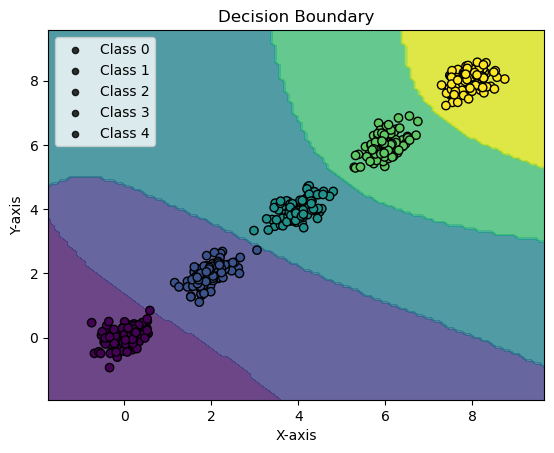

In [186]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_decision_boundary(model, X, y, n_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

# After training
plot_decision_boundary(model, X, y, n_classes)
